In [141]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

In [142]:
# Path do dataset local
DATASET_DIR = 'dataset'

# Verifica se o dataset local existe
def get_breast_cancer_dataset():
    if os.path.exists(DATASET_DIR):
        csv_dir = os.path.join(DATASET_DIR, 'csv')
        jpeg_dir = os.path.join(DATASET_DIR, 'jpeg')
        
        # Verifica se tem as subpastas necessárias
        has_csv = os.path.exists(csv_dir) and os.path.isdir(csv_dir)
        has_jpeg = os.path.exists(jpeg_dir) and os.path.isdir(jpeg_dir)
        
        if has_csv and has_jpeg:
            print(f"Dataset carregado na pasta {DATASET_DIR}")
            return DATASET_DIR
        else:
            print(f"Pasta de dados existente mas não tem estrutura completa:")
            return None
    else:
        print(f"Dataset local não encontrado em: {DATASET_DIR}")
        return None

dataset_path = get_breast_cancer_dataset()

if not dataset_path:
    print("\nErro ao carregar o dataset")


Dataset carregado na pasta dataset


Carregamento correto de imagens usando CSVs oficiais para mapeamento preciso de benigno vs maligno


In [143]:
# Detectação de imagens tipo máscara/ROI

def is_mask_like(gray_img):
    if gray_img is None:
        return True
    
    # Garante uint8
    if gray_img.dtype != np.uint8:
        max_val = gray_img.max() if gray_img.size > 0 else 0
        if max_val <= 1.0:
            gray = (gray_img * 255).astype(np.uint8)
        else:
            gray = gray_img.astype(np.uint8)
    else:
        gray = gray_img
    
    # Poucos valores únicos + grande fundo preto indica máscara
    unique_vals = np.unique(gray)
    if unique_vals.size <= 10:
        black_ratio = np.mean(gray < 10)
        white_ratio = np.mean(gray > 245)
        if black_ratio > 0.85 and white_ratio < 0.2:
            return True
    
    return False

# 🔹 Passo 2: Carregar imagens usando CSVs do CBIS-DDSM-DATASET
IMG_SIZE = (384, 384)
MAX_IMAGES = 100  # Limite de 100 imagens para treino

# 🔹 Passo 2a: Mapeamento de labels do repositório CBIS-DDSM-DATASET
# 1 – Malignant Calcification
# 2 – Benign Calcification
# 3 – Malignant Mass
# 4 – Benign Mass

def map_retrieval_label(label_value):
    if pd.isna(label_value):
        return None
    try:
        label_int = int(label_value)
    except Exception:
        return None

    if label_int in [1, 3]:
        return 1  # Maligno
    if label_int in [2, 4]:
        return 0  # Benigno
    return None


def load_images_from_retrieval_csv(dataset_path, max_images=MAX_IMAGES, img_size=IMG_SIZE):
    csv_dir = os.path.join(dataset_path, 'csv')
    candidate_files = [
        os.path.join(csv_dir, 'training_dataset.csv'),
        os.path.join(csv_dir, 'test_dataset.csv')
    ]

    existing_files = [f for f in candidate_files if os.path.exists(f)]
    if not existing_files:
        return None, None

    all_rows = []
    for csv_path in existing_files:
        try:
            df = pd.read_csv(csv_path)
            print(f" {os.path.basename(csv_path)}: {len(df)} registros")
            all_rows.append(df)
        except Exception as e:
            print(f"   ⚠️ Erro ao ler {csv_path}: {e}")

    if not all_rows:
        return None, None

    combined_df = pd.concat(all_rows, ignore_index=True)

    # Normaliza nomes das colunas
    cols_lower = {c.lower(): c for c in combined_df.columns}
    mammogram_col = cols_lower.get('mammogram path')
    label_col = cols_lower.get('label')

    if mammogram_col is None or label_col is None:
        print("CSV do CBIS-DDSM-DATASET não tem colunas esperadas (Mammogram Path, Label)")
        return None, None

    images = []
    labels = []
    skipped_no_path = 0
    skipped_no_label = 0
    skipped_no_file = 0
    skipped_mask = 0

    for _, row in combined_df.iterrows():
        if len(images) >= max_images:
            break

        img_path_str = str(row.get(mammogram_col, '')).strip()
        if not img_path_str or img_path_str == 'nan':
            skipped_no_path += 1
            continue

        # Mapeia label
        label = map_retrieval_label(row.get(label_col))
        if label is None:
            skipped_no_label += 1
            continue

        # Resolve caminho absoluto
        normalized_path = os.path.normpath(img_path_str)
        if os.path.isabs(normalized_path):
            full_img_path = normalized_path
        else:
            dataset_norm = os.path.normpath(dataset_path)
            if normalized_path.startswith(dataset_norm + os.sep) or normalized_path.startswith('dataset' + os.sep):
                # Caminho já relativo à raiz do projeto
                full_img_path = normalized_path
            else:
                full_img_path = os.path.join(dataset_path, normalized_path)

        if not os.path.exists(full_img_path):
            skipped_no_file += 1
            continue

        # Carrega e processa imagem
        try:
            img = cv2.imread(full_img_path)
            if img is None:
                skipped_no_file += 1
                continue

            # Converte para escala de cinza
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Filtra máscaras/ROI pelo conteúdo
            if is_mask_like(img):
                skipped_mask += 1
                continue

            # Redimensiona
            img = cv2.resize(img, img_size)

            # Normaliza
            img = img.astype('float32') / 255.0

            images.append(img)
            labels.append(label)
        except Exception:
            skipped_no_file += 1
            continue

    print(f" Imagens carregadas: {len(images)}")
    print(f" Excluídos (sem path): {skipped_no_path}")
    print(f" Excluídos (sem label válido): {skipped_no_label}")
    print(f" Excluídos (arquivo não encontrado): {skipped_no_file}")
    print(f" Excluídos (máscara/ROI): {skipped_mask}")

    if len(images) == 0:
        return None, None

    images = np.array(images)
    labels = np.array(labels)

    if len(images.shape) == 3:
        images = np.expand_dims(images, axis=-1)

    return images, labels



# Carrega imagens usando apenas CSVs do CBIS-DDSM-DATASET
if dataset_path:
    X, y = load_images_from_retrieval_csv(dataset_path, max_images=MAX_IMAGES, img_size=IMG_SIZE)
    if X is None or y is None:
        print("CSVs do CBIS-DDSM-DATASET não encontrados em dataset/csv")
        print("Esperado: training_dataset.csv e test_dataset.csv")
        X, y = None, None
    else:
        print(f"\nTotal de imagens carregadas: {len(X) if X is not None else 0}")
else:
    print("Dataset não disponível")
    X, y = None, None


 training_dataset.csv: 2864 registros
 test_dataset.csv: 704 registros
 Imagens carregadas: 100
 Excluídos (sem path): 0
 Excluídos (sem label válido): 0
 Excluídos (arquivo não encontrado): 0
 Excluídos (máscara/ROI): 0

Total de imagens carregadas: 100


Abaixo a separação entre as imagens de treino e teste.


In [144]:
# Separação treino/teste (80/20) com estratificação
if X is not None and y is not None:
    total_images = len(X)
    
    # Verifica distribuição antes do split
    benign_count = np.sum(y == 0)
    malignant_count = np.sum(y == 1)
    
    print(f"Distribuição antes do split:")
    print(f"Total: {total_images}")
    print(f"Benignas: {benign_count} ({benign_count/total_images*100:.1f}%)")
    print(f"Malignas: {malignant_count} ({malignant_count/total_images*100:.1f}%)")
    
    # Split estratificado (mantém proporção de classes)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,  # Mantém proporção de classes
        random_state=42
    )
    
    # Verifica distribuição após split
    train_benign = np.sum(y_train == 0)
    train_malignant = np.sum(y_train == 1)
    test_benign = np.sum(y_test == 0)
    test_malignant = np.sum(y_test == 1)
    
    print(f"\nApós split estratificado:")
    print(f"Treino: {len(X_train)} imagens")
    print(f"- Benignas: {train_benign} ({train_benign/len(y_train)*100:.1f}%)")
    print(f"- Malignas: {train_malignant} ({train_malignant/len(y_train)*100:.1f}%)")
    print(f"Teste: {len(X_test)} imagens")
    print(f"- Benignas: {test_benign} ({test_benign/len(y_test)*100:.1f}%)")
    print(f"- Malignas: {test_malignant} ({test_malignant/len(y_test)*100:.1f}%)")
    
    print(f"\nForma X_train: {X_train.shape}")
    print(f"Forma X_test: {X_test.shape}")
    
    NUM_TRAIN_IMAGES = len(X_train)
    NUM_TEST_IMAGES = len(X_test)
else:
    print("Dados não disponíveis para separação.")
    NUM_TRAIN_IMAGES = 0
    NUM_TEST_IMAGES = 0


Distribuição antes do split:
Total: 100
Benignas: 64 (64.0%)
Malignas: 36 (36.0%)

Após split estratificado:
Treino: 80 imagens
- Benignas: 51 (63.7%)
- Malignas: 29 (36.2%)
Teste: 20 imagens
- Benignas: 13 (65.0%)
- Malignas: 7 (35.0%)

Forma X_train: (80, 384, 384, 1)
Forma X_test: (20, 384, 384, 1)


Abaixo o modelo sequencial para rede neural convolucional com:
- Camadas convolucionais (Conv2D) com ReLU
- Camadas de MaxPooling
- Flatten
- Camadas Dense (fully connected)


In [145]:
# Criação do modelo CNN 
if X_train is not None:
    # Criou um modelo sequencial para rede neural convolucional
    model = models.Sequential()
    
    # Primeira camada convolucional com 32 filtros de tamanho 3x3 e função de ativação ReLU
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(384, 384, 1)))
    
    # Adiciona uma camada de max pooling 2x2 para reduzir a dimensionalidade
    model.add(layers.MaxPooling2D(2, 2))
    
    # Segunda camada convolucional com 64 filtros de tamanho 3x3 e função de ativação ReLU
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    # Adiciona uma segunda camada de max pooling
    model.add(layers.MaxPooling2D(2, 2))
    
    # Terceira camada convolucional com 64 filtros de tamanho 3x3 e ReLU
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    # Adiciona uma camada flatten para converter os mapas de características em um vetor
    model.add(layers.Flatten())
    
    # Adiciona uma camada totalmente conectada com 64 unidades e função de ativação ReLU
    model.add(layers.Dense(64, activation='relu'))
    
    # Adiciona uma camada de saída totalmente conectada com 2 unidades (benigno/maligno) 
    # e função de ativação softmax para classificação
    model.add(layers.Dense(2, activation='softmax'))
    
    # Resumo do modelo
    model.summary()
else:
    print("Dados não disponíveis para criar modelo.")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)              │ (None, 382, 382, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 191, 191, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 189, 189, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 94, 94, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 92, 92, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 541696)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │    34,668,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,724,482 (132.46 MB)

 Trainable params: 34,724,482 (132.46 MB)

 Non-trainable params: 0 (0.00 B)

Compilação do modelo com métricas essenciais para diagnóstico de câncer:
- **ADAM**: Otimizador popular
- **Loss**: sparse_categorical_crossentropy
- **Métricas**: Accuracy, Precision, Recall, AUC (essenciais para câncer - recall de maligno é crítico)


In [ ]:
# Compilação do modelo
if 'model' in locals():
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']  # Apenas accuracy na compilação
    )
    print("Modelo compilado com sucesso!")
else:
    print("Erro ao compilar modelo")


Modelo compilado com sucesso!


Configurações fixas otimizadas para CPU e treinamento rápido:
- **EPOCHS**: 5 (fixo) - número reduzido para não demorar muito
- **BATCH SIZE**: 8 (fixo) - adequado para processamento em CPU

Estes valores garantem um treinamento eficiente sem sobrecarregar a CPU.

In [ ]:
if 'model' in locals() and X_train is not None and y_train is not None:

    NUM_EPOCHS = 5
    BATCH_SIZE = 8
    
    # Garante que batch_size não seja maior que o tamanho do treino
    num_train_images = len(X_train)
    BATCH_SIZE = min(BATCH_SIZE, num_train_images)
    BATCH_SIZE = int(BATCH_SIZE)
    
    # Garante que batch_size seja pelo menos 1
    if BATCH_SIZE < 1:
        BATCH_SIZE = 1
    
    # Garante que y_train seja numpy array e int
    y_train_array = np.array(y_train).astype(np.int32)
    y_test_array = np.array(y_test).astype(np.int32) if len(y_test) > 0 else None
    
    # Verifica se há ambas as classes
    unique_labels = np.unique(y_train_array)
    if len(unique_labels) < 2:
        print("Apenas uma classe presente no treino. Não é possível aplicar class weights.")
        raise ValueError("Treinamento abortado: class weights exigem ambas as classes.")
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=y_train_array
    )
    class_weight_dict = {0: float(class_weights[0]), 1: float(class_weights[1])}
    
    print(f"Classe para benigno (0): {class_weight_dict[0]:.4f}")
    print(f"Classe para maligno (1): {class_weight_dict[1]:.4f}")
    
    print(f"\nConfigurando treinamento:")
    print(f"Imagens de treino: {num_train_images}")
    print(f"Épocas: {NUM_EPOCHS} (fixo para CPU)")
    print(f"Batch size: {BATCH_SIZE} (fixo para CPU)")
    
    # Prepara validation_data de forma segura
    validation_data = None
    if y_test_array is not None and len(X_test) > 0 and len(y_test_array) > 0:
        if len(X_test) == len(y_test_array):
            validation_data = (X_test, y_test_array)
            print(f"Validation data: {len(X_test)} amostras")
        else:
            raise ValueError("X_test e y_test têm tamanhos diferentes.")
    else:
        print("Validation data não disponível")
    
    # Treina o modelo com class weights
    print("Aplicando class weights")
    history = model.fit(
        X_train,
        y_train_array,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=validation_data,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    print("\nTreinamento concluído!")
else:
    print("Erro ao treinar modelo")


Classe para benigno (0): 0.7843
Classe para maligno (1): 1.3793

Configurando treinamento:
Imagens de treino: 80
Épocas: 5 (fixo para CPU)
Batch size: 8 (fixo para CPU)
Validation data: 20 amostras
Aplicando class weights
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.5625 - loss: 1.0738 - val_accuracy: 0.6000 - val_loss: 0.6749
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.6000 - loss: 0.6817 - val_accuracy: 0.6500 - val_loss: 0.6744
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - accuracy: 0.7125 - loss: 0.6292 - val_accuracy: 0.7500 - val_loss: 0.5274
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.8375 - loss: 0.4169 - val_accuracy: 0.6000 - val_loss: 0.4516
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.9125 - loss: 0.2450 - val_accuracy: 0.8000 - val_loss: 0.3637

Treinamento concluído!


Avaliação com métricas essenciais para câncer:
- **Precision, Recall, AUC**: Mais importantes que accuracy para diagnóstico
- **Threshold explícito**: Não usar 0.5 às cegas (ajustar via ROC)
- **Recall de maligno**: CRÍTICO - falso negativo pode ser fatal



Métricas básicas no teste:
Loss: 0.3637
Accuracy: 0.8000
Predições com threshold explícito:
Threshold usado: 0.35
Predições (threshold 0.35): 7 malignas, 13 benignas
Predições (argmax/0.5): 5 malignas, 15 benignas

Métricas essenciais para câncer (threshold 0.35):
Precision: 0.7143
Recall: 0.7143
AUC: 0.9011

Relatório de classificação (threshold 0.35):
              precision    recall  f1-score   support

     Benigno       0.85      0.85      0.85        13
     Maligno       0.71      0.71      0.71         7

    accuracy                           0.80        20
   macro avg       0.78      0.78      0.78        20
weighted avg       0.80      0.80      0.80        20


Matriz de confusão (threshold 0.35):
[[11  2]
 [ 2  5]]

RECALL DE MALIGNO: 0.7143 ⚠️ CRÍTICO
Precision de maligno: 0.7143
Falsos negativos: 2 - CRÍTICO para câncer!
Verdadeiros positivos: 5
Falsos positivos: 2

Predições detalhadas (20 imagens):
Real=Benigno, Predito=Benigno (confiança: 99.8%)
Real=Benigno, Predi

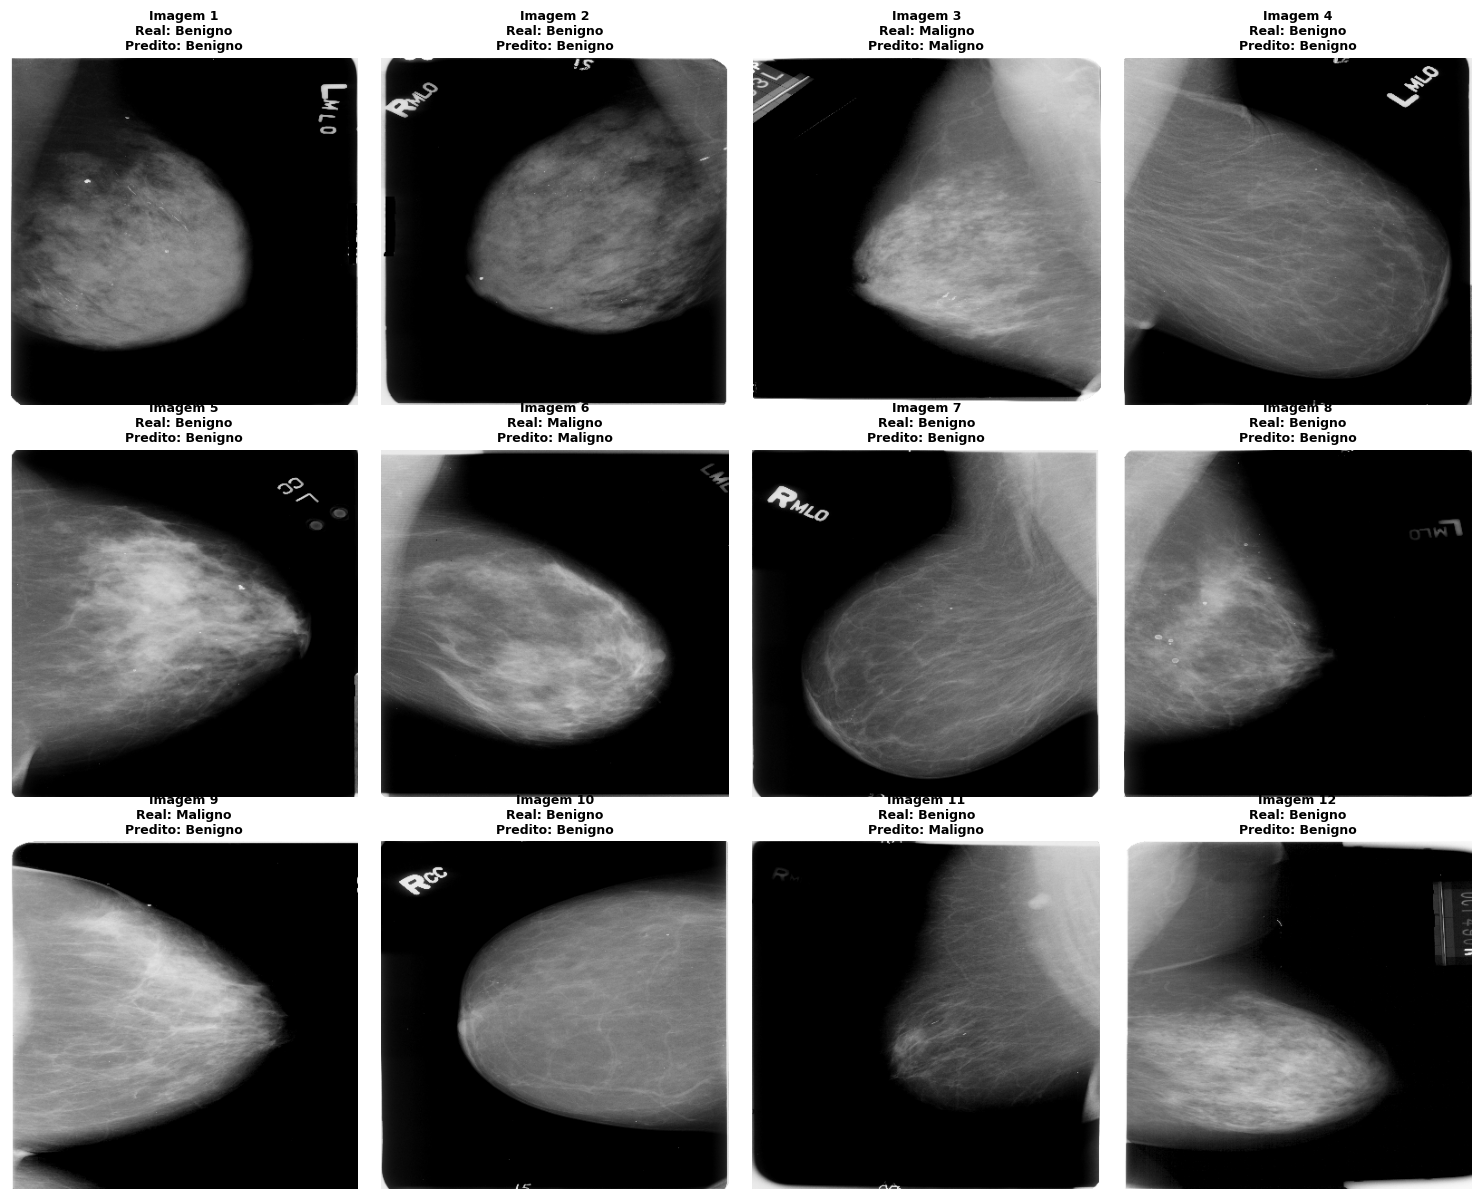

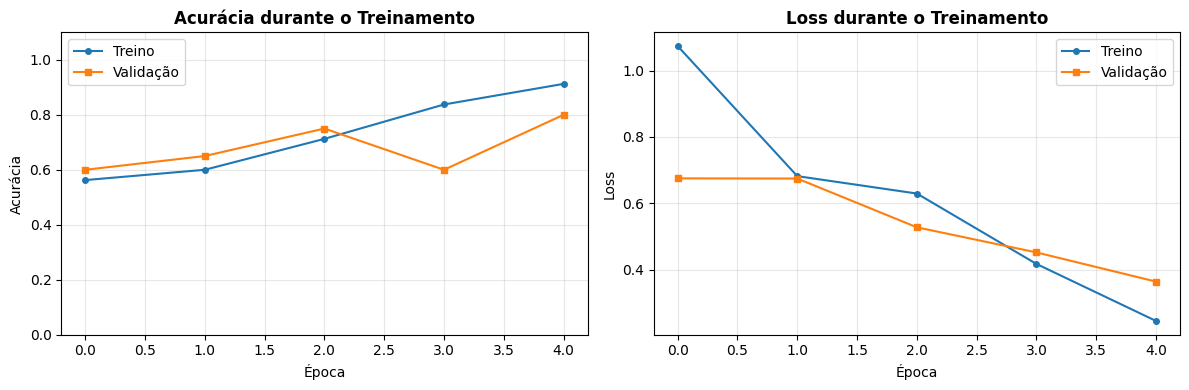


Estatísticas finais:
Acurácia treino: 0.9125
Acurácia validação: 0.8000
Diferença: 0.1125


In [ ]:
# Avaliação com métricas essenciais para câncer
if 'model' in locals() and X_test is not None and len(X_test) > 0:
    num_test_images = len(X_test)
    
    # Avaliação do modelo com métricas básicas
    eval_results = model.evaluate(X_test, y_test, verbose=0)
    
    # Extrai métricas básicas (loss, accuracy)
    test_loss = eval_results[0]
    test_accuracy = eval_results[1]
    
    print(f"\nMétricas básicas no teste:")
    print(f"Loss: {test_loss:.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")
    
    # Predições com probabilidades
    y_pred_prob = model.predict(X_test, verbose=0)
    
    #limiar de decisão
    threshold = 0.35 
    # y_pred_prob é shape (n_samples, 2) - pega probabilidade da classe 1 (maligno)
    y_pred_malignant_prob = y_pred_prob[:, 1]
    y_pred_threshold = (y_pred_malignant_prob >= threshold).astype(int)
    
    # Também calcula com argmax - limiar padrão 0.5 para comparar com threshold
    predicted_classes_argmax = np.argmax(y_pred_prob, axis=1)
    
    print(f"Predições com threshold explícito:")
    print(f"Threshold usado: {threshold}")
    print(f"Predições (threshold {threshold}): {np.sum(y_pred_threshold)} malignas, {np.sum(1-y_pred_threshold)} benignas")
    print(f"Predições (argmax/0.5): {np.sum(predicted_classes_argmax)} malignas, {np.sum(1-predicted_classes_argmax)} benignas")
    
    # Calcula métricas essenciais manualmente
    from sklearn.metrics import (
        classification_report, 
        confusion_matrix, 
        precision_score, 
        recall_score, 
        roc_auc_score,
        roc_curve
    )
    
    # Calcula métricas com threshold explícito
    precision = precision_score(y_test, y_pred_threshold, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred_threshold, average='binary', zero_division=0)
    
    # AUC - cálculo da área sob a curva ROC
    try:
        auc = roc_auc_score(y_test, y_pred_malignant_prob)
    except:
        auc = 0.0
    
    print(f"\nMétricas essenciais para câncer (threshold {threshold}):")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC: {auc:.4f}")
    
    print(f"\nRelatório de classificação (threshold {threshold}):")
    print(classification_report(y_test, y_pred_threshold, target_names=['Benigno', 'Maligno'], zero_division=0))
    
    print(f"\nMatriz de confusão (threshold {threshold}):")
    cm = confusion_matrix(y_test, y_pred_threshold)
    print(cm)
    
    # Foco em recall de maligno (classe 1)
    if cm.size == 4:  # Matriz 2x2
        tn, fp, fn, tp = cm.ravel()
        recall_malignant = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision_malignant = tp / (tp + fp) if (tp + fp) > 0 else 0
        print(f"\nRECALL DE MALIGNO: {recall_malignant:.4f}")
        print(f"Precision de maligno: {precision_malignant:.4f}")
        print(f"Falsos negativos: {fn} - CRÍTICO para câncer!")
        print(f"Verdadeiros positivos: {tp}")
        print(f"Falsos positivos: {fp}")
    
    # Usa predições com threshold para visualização
    predicted_classes = y_pred_threshold
    
    print(f"\nPredições detalhadas ({num_test_images} imagens):")
    for i in range(min(20, num_test_images)): 
        true_label = "Benigno" if y_test[i] == 0 else "Maligno"
        pred_label = "Benigno" if predicted_classes[i] == 0 else "Maligno"
        confidence = y_pred_malignant_prob[i] * 100 if predicted_classes[i] == 1 else (1 - y_pred_malignant_prob[i]) * 100
        print(f"Real={true_label}, Predito={pred_label} (confiança: {confidence:.1f}%)")
    
    if num_test_images > 20:
        print(f"... ({num_test_images - 20} imagens restantes)")
    
    # Ajusta o layout baseado no número de imagens
    if num_test_images == 1:
        # Uma única imagem: exibe maior
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(X_test[0].squeeze(), cmap='gray')
        true_label = "Benigno" if y_test[0] == 0 else "Maligno"
        pred_label = "Benigno" if predicted_classes[0] == 0 else "Maligno"
        confidence = y_pred_malignant_prob[0] * 100 if predicted_classes[0] == 1 else (1 - y_pred_malignant_prob[0]) * 100
        status = "Correto" if y_test[0] == predicted_classes[0] else "Errado"
        ax.set_title(f"Real: {true_label}\nPredito: {pred_label}\nConfiança: {confidence:.1f}%\n{status}", 
                    fontsize=12, fontweight='bold')
        ax.axis('off')
    elif num_test_images <= 4:
        # Poucas imagens: exibe em linha
        fig, axes = plt.subplots(1, num_test_images, figsize=(4*num_test_images, 4))
        if num_test_images == 1:
            axes = [axes]
        for i in range(num_test_images):
            axes[i].imshow(X_test[i].squeeze(), cmap='gray')
            true_label = "Benigno" if y_test[i] == 0 else "Maligno"
            pred_label = "Benigno" if predicted_classes[i] == 0 else "Maligno"
            confidence = y_pred_malignant_prob[i] * 100 if predicted_classes[i] == 1 else (1 - y_pred_malignant_prob[i]) * 100
            status = "OK" if y_test[i] == predicted_classes[i] else "ERRO"
            axes[i].set_title(f"Real: {true_label}\nPredito: {pred_label}\n({confidence:.0f}%) {status}", 
                            fontsize=10, fontweight='bold')
            axes[i].axis('off')
    elif num_test_images <= 12:
        # Múltiplas imagens: exibe em grid 2xN ou 3xN
        cols = 4
        rows = (num_test_images + cols - 1) // cols  # Arredonda para cima
        fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
        axes = axes.flatten() if rows > 1 else [axes] if cols == 1 else axes
        
        for i in range(num_test_images):
            axes[i].imshow(X_test[i].squeeze(), cmap='gray')
            true_label = "Benigno" if y_test[i] == 0 else "Maligno"
            pred_label = "Benigno" if predicted_classes[i] == 0 else "Maligno"
            confidence = y_pred_malignant_prob[i] * 100 if predicted_classes[i] == 1 else (1 - y_pred_malignant_prob[i]) * 100
            status = "OK" if y_test[i] == predicted_classes[i] else "ERRO"
            axes[i].set_title(f"Imagem {i+1}\nReal: {true_label}\nPredito: {pred_label}\n({confidence:.0f}%) {status}", 
                            fontsize=9, fontweight='bold')
            axes[i].axis('off')
        
        # Esconde eixos vazios
        for i in range(num_test_images, len(axes)):
            axes[i].axis('off')
    else:
        print(f"Exibindo apenas as primeiras 12 de {num_test_images} imagens")
        cols = 4
        rows = 3
        fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
        axes = axes.flatten()
        
        for i in range(min(12, num_test_images)):
            axes[i].imshow(X_test[i].squeeze(), cmap='gray')
            true_label = "Benigno" if y_test[i] == 0 else "Maligno"
            pred_label = "Benigno" if predicted_classes[i] == 0 else "Maligno"  
            axes[i].set_title(f"Imagem {i+1}\nReal: {true_label}\nPredito: {pred_label}", 
                            fontsize=9, fontweight='bold')
            axes[i].axis('off')
        
        # Esconde eixos vazios
        for i in range(12, len(axes)):
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Gráficos para validação de treinamento
    if 'history' in locals():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Gráfico de accuracy
        ax1.plot(history.history['accuracy'], label='Treino', marker='o', markersize=4)
        if 'val_accuracy' in history.history:
            ax1.plot(history.history['val_accuracy'], label='Validação', marker='s', markersize=4)
        ax1.set_title('Acurácia durante o Treinamento', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Época')
        ax1.set_ylabel('Acurácia')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        ax1.set_ylim([0, 1.1])
        
        # Gráfico de loss
        ax2.plot(history.history['loss'], label='Treino', marker='o', markersize=4)
        if 'val_loss' in history.history:
            ax2.plot(history.history['val_loss'], label='Validação', marker='s', markersize=4)
        ax2.set_title('Loss durante o Treinamento', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Época')
        ax2.set_ylabel('Loss')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Estatísticas adicionais
        if 'val_accuracy' in history.history:
            final_train_acc = history.history['accuracy'][-1]
            final_val_acc = history.history['val_accuracy'][-1]
            gap = abs(final_train_acc - final_val_acc)
            print(f"\nEstatísticas finais:")
            print(f"Acurácia treino: {final_train_acc:.4f}")
            print(f"Acurácia validação: {final_val_acc:.4f}")
            print(f"Diferença: {gap:.4f}")
else:
    print("Dados não disponíveis para avaliação.")
